<a href="https://colab.research.google.com/github/sahil3Vedi/digit-recogniser-py/blob/master/Deep_Learning_on_MNIST_without_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#declaring all the dependencies NO KERAS OR TENSORFLOW
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
from google.colab import drive
from math import e
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neural Network is Trained in 4 Stages:

1) Network recieves input from model
FUNCTION: NN.getInput(model.inputList)
VARIABLES INVOLVED: NN.layers[0].inputVals

2) Network activates one layer after the other.
FUNCTION: NN.activate(activationFunction)
VARIABLES INVOLVED: NN.layers[i].inputVals, NN.layers[i].activations, NN.layers[i].activDerivates, NN.layers[i].layerWeights, NN.layers[i].bias, NN.layers[i].biasWeights

3) Model calculates cost from the target value of input data and answer provided by network.
FUNCTION: model.getCost(NN)
VARIABLES INVOLVED: NN.layers[-1].activations, NN.layers[-1].forwardError, model.cost

4) Network readjusts the weights based on the cost and error information.
FUNCTION: NN.backpropagate()
VARIABLES INVOLVED: NN.layers[i].forwardError, NN.layers[i].diffWeights, NN.layers[i].diffBias, NN.layers[i-1].activations, NN.layers[i-1].forwardError

In [0]:
class neuralNetwork:
  layers=[]
  finalError=[]
  inputElem=0
  hiddenElem=0
  outputElem=0
  
  #When a neural network is declared 
  def __init__(self):
    self.inputElem=784
    self.outputElem=10
    self.hiddenElem=30
    
    inputLayer = layer(self.inputElem,"normalize",None)
    self.layers.append(inputLayer)
    
    temp = layer(self.hiddenElem,"tanH",self.layers[0])
    self.layers.append(temp)
    temp = layer(self.hiddenElem,"tanH",self.layers[1])
    self.layers.append(temp)
    #temp = layer(self.hiddenElem,"tanH",self.layers[2])
    #self.layers.append(temp)
    
    outputLayer = layer(self.outputElem,"sigmoid",self.layers[2])
    self.layers.append(outputLayer)
    #TOTAL 5 LAYERS
    print("Neural Network Initialised...")
    
  def getInput(self,i):
    self.layers[0].inputVals=i
    
  def dropout(self,x,y):
    stu=[]
    tempp=[]
    tempq=[]
    for i in range(len(x)):
      k=np.random.random_sample()
      m=x[i]
      n=y[i]
      if k<0:
        tempp.append(0)
        tempq.append(0)
      else:
        tempp.append(m)
        tempq.append(n)
    stu.append(tempp)
    stu.append(tempq)
    return stu
    
  def activate(self):
    for i in range(0,len(self.layers)):
      temp=self.layers[i].inputVals
      activation=self.layers[i].activation
      
      if (activation=="normalize"):#typically used for the input layer. if you ask me it makes perfect sense to treat normalisation as input layer activation.
        temp2=[(-1+(int(x)*2)/255) for x in temp]
        temp3=temp2 #this is because normalise is only being used on input layer where we dont need any back prop hence no need to calculate derivative.
      
      if (activation=="ReLU"):
        temp2=[]
        temp3=[]
        for x in temp:
          if (x>0):
            y=x
            z=1
          else:
            y=0.0000001*x
            z=0.0000001
          temp3.append(z)
          temp2.append(y)
          
      if (activation=="tanH"):
        temp2=[]
        temp3=[]
        for x in temp:
          a=e**(0.5*x)
          b=e**(-0.5*x)
          temp2.append((a-b)/(a+b))
        for y in temp2:
          temp3.append(0.5*(1-(y**2)))
          
      if (activation=="sigmoid"):
        temp2=[]
        temp3=[]
        for x in temp:
          sgm=1/(1+e**(-x))
          temp2.append(sgm)
        for y in temp2:
          dev=y*(1-y)
          temp3.append(dev)
          
      if (activation=="softMax"):
        evec=[e**x for x in temp]
        esum=np.sum(evec)
        temp2=[y/esum for y in evec]
        temp3=[q*(1-q) for q in temp2]
        
      if (activation=="tanH" or activation=="ReLU"):  
        stub=self.dropout(temp2,temp3)
      else:
        stub=[]
        stub.append(temp2)
        stub.append(temp3)
      
      self.layers[i].activations=stub[0]
      self.layers[i].activDerivatives=stub[1]
      
      if(i!=len(self.layers)-1):#this is because we dont need to feed forward beyond the output layer.
        self.layers[i].feedForward(self.layers[i+1])
  
  def backpropagate(self):
    for i in range(len(self.layers)):
      ind=-i-1
      if(i!=len(self.layers)-1):
        self.layers[ind].updateWeights(self.layers[ind-1])

In [0]:
class model:
  epoch=0
  learningRate=0.01
  cost=0
  target=0
  inputFile=[]
  trainingEntries=0
  accuracy=0
  accuracies=[]
  costs=[]
  epochs=[]
  
  def plotLoss(self):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(self.epochs,self.accuracies)
    plt.show()
    
  def response(self,NN):
    #updating learning rate
    self.learningRate=(self.cost)*(0.03)/(0.449)
    maxI=max(NN.layers[-1].activations)
    indX=NN.layers[-1].activations.index(maxI)
    if(str(self.target)==str(indX)):
      self.accuracy+=1
    self.epoch+=1
    if(self.epoch%5000==0):
      self.plotLoss()
    if(self.epoch%500==0):
      print("Epoch: " + str(self.epoch) + " Cost: " + str(self.cost) + " Target: " + str((self.target)) + " Answer : " + str(indX))
      print(NN.layers[-3].activations)
      print("Accuracy: " + str(self.accuracy))
    if(self.epoch%100==0):
      #Adding accuracy cost and epoch for plotting.
      self.costs.append(self.cost)
      self.accuracies.append(self.accuracy)
      self.epochs.append(self.epoch)
      self.accuracy=0
  
  def getInput(self,inputFile):
    with open(inputFile) as csvFile:
      csvReader = csv.reader(csvFile)
      self.inputFile = list(csvReader)
      self.trainingEntries = len(self.inputFile)-1  #n-1 because first row is header row
      print("Total entries excluding header: " + str(self.trainingEntries) + " rows")
      
  def getCost(self,NN):
    targetVector=[]
    for i in range(10):
      if (str(i)==str(self.target)):
        targetVector.append(1)
      else:
        targetVector.append(0)
    output=NN.layers[-1].activations
    error=[x-y for (x,y) in zip(output,targetVector)]
    self.cost=0.5*(np.sum(np.square(error)))
    NN.layers[-1].forwardError=error
      
  def trainNetwork(self,NN):
    inputList=self.inputFile
    inputList.pop(0)
    for i in inputList:
      self.target=i[0]
      i.pop(0)
      NN.getInput(i)
      NN.activate()
      self.getCost(NN)
      NN.backpropagate()
      Model.response(NN)
      
  def invCross(self,l1,l2): #this is the ONLY part that
    temp=[]
    for x in l1:
      temptemp=[]
      for y in l2:
        temptemp.append(x*y)
      temp.append(temptemp)
    return temp
      

In [0]:
class layer:
  numberElements=0
  bias=0
  activation="default"
  inputVals=[]
  activations=[]
  activDerivatives=[]
  forwardError=[]
  layerWeights=[]
  biasWeights=[]
  
  #When a layer is declared
  def __init__(self,no_of_elements,activation,previousLayer):
    self.numberElements=no_of_elements
    self.bias=0.1
    self.activation=activation
    #Initialising the Weight Matrix
    temp=[]
    if(previousLayer!=None):
      for i in range(previousLayer.numberElements):
        temptemp=[]
        for j in range(self.numberElements):
          temptemp.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
        temp.append(temptemp)
    self.layerWeights=temp
    #Initialising the Bias Matrix
    self.biasWeights=[]
    for i in range(self.numberElements):
      self.biasWeights.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
      
  def feedForward(self,nextLayer):
    tempbias=self.bias
    biasVec=nextLayer.biasWeights
    temp2=np.matmul(self.activations,nextLayer.layerWeights)
    temp3=np.multiply(tempbias,biasVec)
    nextLayer.inputVals=[x+y for (x,y) in zip(temp2,temp3)]
    
  def updateWeights(self,prevLayer):
    #declaring the Differential diagonal matrix
    dmx=[]
    for i in range(self.numberElements):
      dtemp=[]
      oi=self.activations[i]
      for j in range(self.numberElements):
        if(i==j):
          dtemp.append(oi*(1-oi))
        else:
          dtemp.append(0)
      dmx.append(dtemp)
    #declaring do vector
    dovec=np.matmul(dmx,self.forwardError)
    wmx=Model.invCross(dovec,prevLayer.activations)
    bvec=np.multiply((self.bias*Model.learningRate),dovec)
    wMx=np.multiply(Model.learningRate,wmx)
    tempW=np.subtract(self.layerWeights,np.transpose(wMx))
    tempB=np.subtract(self.biasWeights,bvec)
    self.layerWeights=tempW
    prevLayer.forwardError=np.matmul(self.layerWeights,dovec)
    
    

Total entries excluding header: 42000 rows
Neural Network Initialised...
Epoch: 500 Cost: 0.46250536770196005 Target: 9 Answer : 2
[0.15579242676945929, 0.9843753360383402, 0.9309896249801762, 0.9955652653458337, 0.9733419762137, -0.39401588333792925, 0.6736141607047078, 0.9271530215252883, -0.6930825503804189, 0.5026879879462101, 0.059807633121061285, 0.9610066058426343, 0.2195672075268401, 0.9492137261947264, 0.37959445110143897, -0.682684200066605, 0.725375801085207, -0.9220996994859361, 0.975647752181328, 0.8302439085318604, -0.7788296380156889, -0.48987918080733406, -0.4307224495706558, 0.32022620350381403, 0.981401098183382, 0.5824698174739802, -0.0848752268964852, 0.504251378105626, 0.9690827824169498, 0.9976421724632096]
Accuracy: 16
Epoch: 1000 Cost: 0.45209460398554746 Target: 4 Answer : 2
[-0.03687287847427455, 0.998617492157255, -0.40454832069605884, 0.978182325959446, 0.9898740972915521, -0.45250519122640354, 0.8913842974315095, 0.9905614375855575, -0.49624700164931357, -0

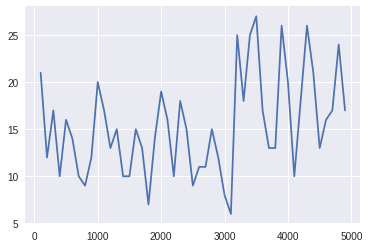

Epoch: 5000 Cost: 0.45928594011135426 Target: 9 Answer : 1
[0.3162867766327249, 0.9951808745813647, 0.5697701295532012, 0.9280692593233562, 0.9884746367056595, -0.015095294363085971, 0.9852030679104282, 0.9976425336109452, 0.14001029207372792, 0.4128627606185294, 0.10120383440130376, 0.9978894502470984, 0.9370929339889765, 0.967554187290333, 0.9209441894856067, 0.8728399563720796, 0.9974849362464688, -0.3342002451104243, 0.9983531698302157, 0.9455230389782623, -0.01873692703399211, 0.8091552236290361, 0.2510984917993723, 0.8582446725773177, 0.9990488111224495, -0.8529756882418914, 0.63034921575364, 0.7380995424993568, 0.9976517064674287, 0.9804735832058613]
Accuracy: 12
Epoch: 5500 Cost: 0.44407247618282214 Target: 4 Answer : 2
[0.15488393033634484, 0.9940863037198804, -0.14325336522479643, 0.9882447190670447, 0.9986606147952573, 0.21432045200367156, 0.91610172024628, 0.9989890823192075, 0.06812109945189881, 0.07537619744255125, -0.25591934671208144, 0.9720816184717731, 0.6881041243470

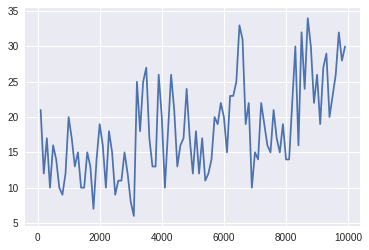

Epoch: 10000 Cost: 0.4547844407572884 Target: 9 Answer : 1
[0.8646226398121962, 0.9435440902038136, 0.8226932431215243, 0.793020098415553, 0.992697110969229, 0.9628794597785406, 0.9175600935273357, 0.9909900076735274, -0.9975095435160122, 0.3728264921592595, 0.8751968134622747, 0.9987221053410229, 0.34760019755695837, 0.9596368380104371, 0.4315167188025734, 0.7706844899141376, 0.9834419276834041, 0.4656966511659361, 0.9695683133026093, 0.9348452625868153, -0.9987855453552251, 0.6387474512000445, 0.8050460740095655, 0.4404209228814848, 0.9906491114921343, 0.9646091358487395, 0.8277941782012361, 0.9447454261923246, 0.9493252373196391, 0.9995308886717534]
Accuracy: 29
Epoch: 10500 Cost: 0.46465578455332923 Target: 9 Answer : 1
[0.49463983653767146, 0.991416848138339, 0.5749799155538623, 0.3340161062663593, 0.9859015196143331, 0.9601265540153784, 0.9785580964173674, 0.996552606622619, -0.9826658486513894, 0.5412139149329245, 0.7389941670020912, 0.9959822250992351, 0.8411844313390375, 0.852

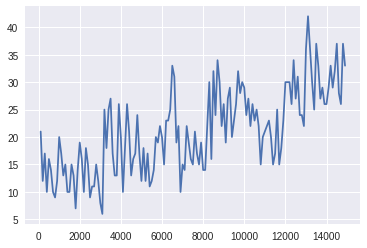

Epoch: 15000 Cost: 0.4466368434408967 Target: 6 Answer : 0
[0.9365501022074407, 0.9987701641233255, 0.7213319164331893, 0.9737260719702121, 0.9881302542086968, 0.45328689740868255, 0.9915376364741842, 0.9953176132844531, -0.5880478975602762, 0.9783849409015818, -0.13356201190869504, 0.9924616350734872, 0.8172761359093962, 0.6117954140407191, 0.928137670789495, 0.7014145811495842, 0.9995295053231562, 0.9689679944893961, 0.8390151940105129, 0.13150200303069265, 0.8291772910690649, -0.3519150971702237, 0.9319025690943873, 0.921366748661753, 0.9917141675174653, 0.7691994928941601, 0.3323234391780599, -0.024459251770056544, 0.9983895838133433, 0.9994124070132648]
Accuracy: 36
Epoch: 15500 Cost: 0.4716551370093772 Target: 2 Answer : 1
[0.6751521479401132, 0.9915919923474571, 0.9406328873150089, 0.2483590980468276, 0.974243590190569, 0.71122285736828, 0.972261951500335, 0.9923118061105708, 0.9943480638836206, 0.9700028208129947, 0.63923700904407, 0.9976066311665642, 0.9161569654514582, 0.6117

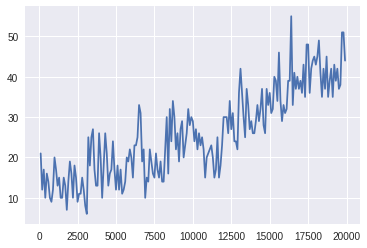

Epoch: 20000 Cost: 0.2433180041573318 Target: 7 Answer : 7
[0.9712323588589813, 0.9908403655447581, 0.0073020574663418885, -0.9999999999999604, 0.957862420022445, 0.9783646771766771, 0.9030948651531961, 0.9693695498544785, 0.3625480149352619, -0.7325683958519464, -0.9999999999999704, 0.9988667595874532, -0.9999999999998479, 0.9475761759606098, -0.9999999999999977, 0.6908603120076572, 0.9978779684901469, -0.3856941818708415, 0.8215501518949792, 0.941430124430297, 0.9262410813814603, 0.9965024586885607, -0.380025122078666, 0.9227534062944722, 0.9990624391324987, 0.9440785142515208, 0.8656855069432496, 0.9340375823265826, 0.9876813072157874, 0.9978785241156151]
Accuracy: 46
Epoch: 20500 Cost: 0.3631590803874533 Target: 6 Answer : 6
[0.5154082594674829, 0.9831828513309113, -0.4261904598135517, -1.0, 0.9748644151333711, 0.7196199411437789, 0.991159588097047, 0.9996390681150611, 0.8806020325302023, 0.730743048496344, -0.9999999946850203, 0.9976766701242281, -0.9999969544239081, 0.34853888225

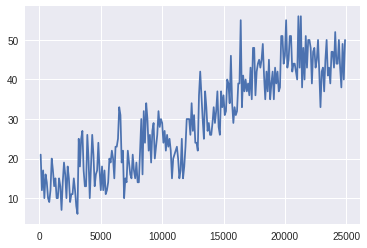

Epoch: 25000 Cost: 0.47018187564918423 Target: 5 Answer : 0
[-1.0, 0.9960118448402278, 0.8728726846768994, -1.0, 0.9271368197486788, 0.38521477669696347, 0.9938437855595248, 0.9986291622176608, 0.8123402137462294, 0.9528578381013334, -1.0, 0.999479087859006, -1.0, 0.8913622700455449, -1.0, -1.0, 0.998230048872548, 0.9482552252274294, -1.0, -1.0, 0.8832155090485168, 0.8986046826439648, 0.9633125383784849, 0.8869251551568779, 0.9970391178110162, -0.05872251584083194, -0.511373644764327, -0.2055800463586682, 0.9995816945293778, 0.9985727866024527]
Accuracy: 49
Epoch: 25500 Cost: 0.42464089293044044 Target: 7 Answer : 5
[-1.0, 0.9878282881950383, 0.7791626425318768, -1.0, 0.8614749691557804, 0.8871733308216346, 0.9899225854613668, 0.9865663858161938, 0.005066585618203432, 0.7879429141471979, -0.9999653356327587, 0.9973233776368257, -0.9999862094580153, 0.9476084743946048, -1.0, -0.9999999946453543, 0.9958353503869299, 0.6099943714394281, -1.0, -1.0, 0.4532496904009379, 0.9131727659283819, 

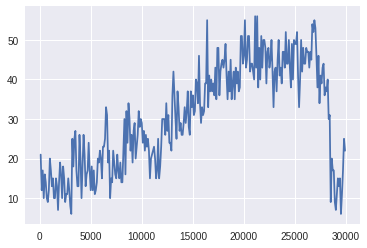

Epoch: 30000 Cost: 0.39296686284968074 Target: 0 Answer : 0
[0.9999999967622085, 0.9988385990518696, 0.9998144272104695, 1.0, -1.0, 0.9977911641888345, 0.9840218752442694, 0.9968013924722431, 0.9983705638740014, 0.9994586590337878, 1.0, 0.9993669612213011, 1.0, 0.9994972762713634, 1.0, 1.0, 0.9948962420536257, 0.9477456952067548, 1.0, 1.0, 0.997007364051595, 0.9999821612461092, 0.8541708434013134, -1.0, 0.999078450917248, 0.9999999999996589, -1.0, -1.0, 0.982339023598068, 0.9955546220093463]
Accuracy: 20
Epoch: 30500 Cost: 0.41896721361385486 Target: 8 Answer : 8
[1.0, 0.9958763455103519, 0.9999950767067416, 1.0, -0.9965530485532853, 0.9999477395440579, 0.8553746532746664, 0.9970954032282772, 0.99989017353099, 0.9998587850411865, 1.0, 0.9998457954122584, 1.0, 0.999876323759382, 0.9999999999999936, 1.0, 0.988705138583933, 0.9977674249657745, 1.0, 0.999999999996921, 0.9998643126000659, 0.9997439978984648, -1.0, -1.0, 0.9994527999642332, 0.9999628586762417, -1.0, -1.0, 0.997029400810958, 

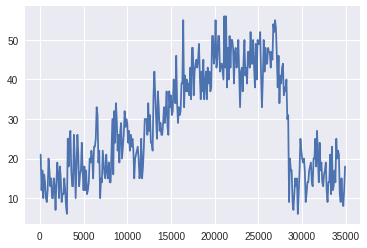

Epoch: 35000 Cost: 0.14089453945843605 Target: 0 Answer : 0
[1.0, -1.0, 0.9999904645277441, 0.9999999999999996, 0.9999425892644188, 0.9996522905744534, 0.9999044549484123, -1.0, 0.9999921001934632, 0.9999553110037424, 1.0, 0.9995755241706006, 1.0, 0.9999935571874156, 1.0, 1.0, 0.9999944886502108, -1.0, 1.0, 1.0, 0.9980928068652978, 0.9999641537033594, -1.0, 1.0, 0.9995715451051979, 0.9999999999999724, -0.9999999999856757, -0.9894171519186457, 0.9427271849623433, 0.9998246260154818]
Accuracy: 14
Epoch: 35500 Cost: 0.4336712479737818 Target: 2 Answer : 6
[1.0, -1.0, 0.9992428818477448, 1.0, 1.0, 0.9981519401471427, 0.9999014546857915, -1.0, 0.9999963243529283, 0.9993586749161292, 1.0, 0.9998958919170953, 1.0, 0.9979221948946261, 1.0, 1.0, 0.9999998876669232, -1.0, 1.0, 1.0, 0.9999681347483372, 0.9998825665836716, 1.0, 1.0, 0.9996755884748326, 0.9976337047906705, 1.0, 1.0, 0.9962052250819221, 0.9991593251730062]
Accuracy: 8
Epoch: 36000 Cost: 0.5051707409592305 Target: 4 Answer : 1
[1.0, 

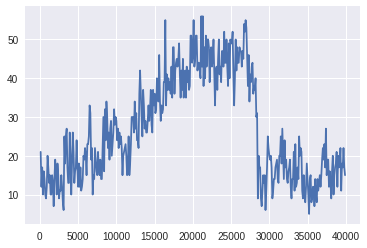

Epoch: 40000 Cost: 0.47065447631881335 Target: 3 Answer : 0
[1.0, -1.0, 0.9999988799055702, 1.0, 1.0, 0.9999939257224251, -1.0, 0.9992228650013001, 0.999997971171342, 0.999989077430813, 1.0, 0.9999453238932297, 1.0, 0.9999981022964302, 1.0, 1.0, 0.9999984651617885, 1.0, 1.0, 0.9999999999999951, 0.9999916822600623, 0.9999970783801718, 1.0, 1.0, 0.9999812918872326, 0.9999995730625707, 1.0, 1.0, 1.0, 0.9991544787527998]
Accuracy: 27
Epoch: 40500 Cost: 0.4292423314266712 Target: 4 Answer : 0
[1.0, -1.0, 0.9999666547737507, 1.0, 1.0, 0.999966191429462, -1.0, 1.0, 0.9999943241733941, 0.9984803917758269, 1.0, 0.9985828215475252, 1.0, 0.9998804764570076, 1.0, 1.0, 0.9999998862224115, 1.0, 1.0, 1.0, 0.9994398423069035, 0.9999089402916236, 1.0, 1.0, 0.9993702858581228, 0.9999999999996441, 1.0, 1.0, 1.0, 0.9994953612463121]
Accuracy: 11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


Epoch: 41000 Cost: nan Target: 6 Answer : 0
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Accuracy: 18


KeyboardInterrupt: ignored

In [20]:
#-----MAIN FUNCTION-----

Model = model()
inputFile='drive/My Drive/MNIST Image CSV/train.csv'
Model.getInput(inputFile)

NN = neuralNetwork()
Model.trainNetwork(NN)